In [6]:
import pandas as pd

eb = pd.read_csv("emobank.csv", index_col=0)

print(eb.shape)
eb.head()



(10062, 5)


,split,V,A,D,text
id,,,,,
110CYL068_1036_1079,train,3.00,3.00,3.20,"Remember what she said in my last letter? """
110CYL068_1079_1110,test,2.80,3.10,2.80,If I wasn't working here.
110CYL068_1127_1130,train,3.00,3.00,3.00,".."""
110CYL068_1137_1188,train,3.44,3.00,3.22,Goodwill helps people get off of public assist...
110CYL068_1189_1328,train,3.55,3.27,3.46,Sherry learned through our Future Works class ...



## Regression models:

In [7]:
# ! pip install -U sentence-transformers

import sklearn
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sentence_transformers import SentenceTransformer
# Filter the DataFrame first
filtered_eb = eb[eb['text'].notna()]
# Then create arrays
xs = filtered_eb['text'].astype(str).tolist()
ys = np.column_stack((filtered_eb['V'], filtered_eb['A']))
# print(xs.shape,ys.shape)

# convert it to embeddings for NN.

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# model = BertModel.from_pretrained("bert-base-uncased")
#
# tokens = tokenizer(xs, return_tensors="pt", padding=True, truncation=True)
# with torch.no_grad():
#     output = model(**tokens)
#
# embeddings = output.last_hidden_state[:, 0, :]  # Shape: (1, 768)
# xs = embeddings.numpy()

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(xs)
print(embeddings.shape)
xs = embeddings

print(xs.shape)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(xs, ys, test_size=0.2)
# print(y_train.shape, y_test.shape)




(10061, 384)
(10061, 384)


## Random Forest


In [8]:
# null

## Neural Network

C:\Users\louis\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 0: Train Loss = 1.027119, Val Loss = 0.981384
Epoch 10: Train Loss = 0.825692, Val Loss = 0.800564
Epoch 20: Train Loss = 0.678774, Val Loss = 0.694308
Epoch 30: Train Loss = 0.597486, Val Loss = 0.651825
Epoch 40: Train Loss = 0.540327, Val Loss = 0.634502
Epoch 50: Train Loss = 0.492130, Val Loss = 0.630811
Early stopping triggered.
Final Losses:
Train MSE: 0.043492384
Val MSE: 0.056081217
Test MSE: 0.05866436


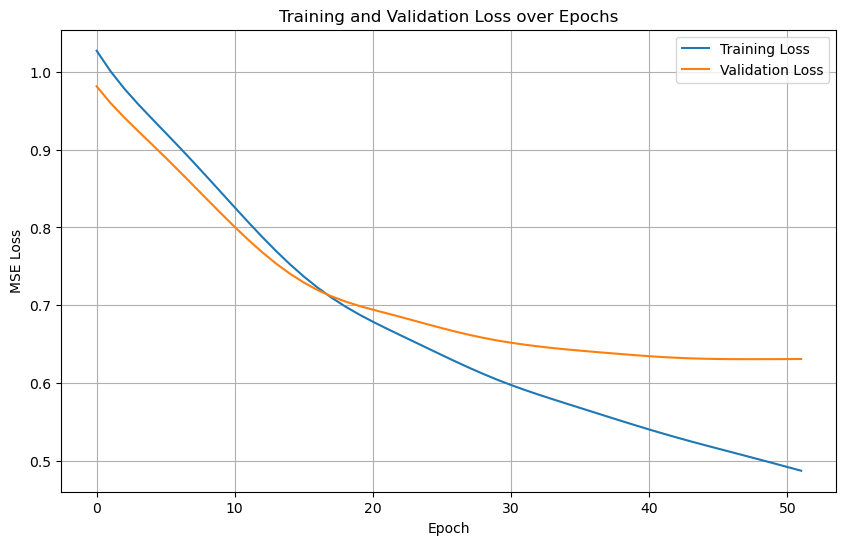

In [33]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, output_size=2):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)

        )

    def forward(self, x):
        return self.network(x)

# Denormalisation helper
def denormalise(y_norm, scaler):
    if isinstance(y_norm, torch.Tensor):
        y_norm = y_norm.detach().cpu().numpy()
    return scaler.inverse_transform(y_norm)

def find_nn(X_train, X_test, y_train, y_test):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    feature_scaler = StandardScaler()
    X_train_norm = feature_scaler.fit_transform(X_train)
    X_test_norm = feature_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train_norm = y_scaler.fit_transform(y_train)
    y_test_norm = y_scaler.transform(y_test)

    X_train_final, val_x, y_train_final, val_y = train_test_split(
        X_train_norm, y_train_norm, test_size=0.2, random_state=42
    )

    X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_final, dtype=torch.float32).to(device)
    val_x_tensor = torch.tensor(val_x, dtype=torch.float32).to(device)
    val_y_tensor = torch.tensor(val_y, dtype=torch.float32).to(device)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_norm, dtype=torch.float32).to(device)

    input_dim = X_train_tensor.shape[1]
    model = NeuralNetworkModel(input_size=input_dim, hidden_size=64, output_size=2).to(device)

    loss_fn = nn.MSELoss()
    optimiser = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=0.5, patience=100, verbose=True)

    epochs = 3000
    patience = 4
    stationary = 0
    min_val_loss = float('inf')
    train_losses = []
    val_losses = []

    torch.manual_seed(1)
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        optimiser.zero_grad()
        train_pred = model(X_train_tensor)
        train_loss = loss_fn(train_pred, y_train_tensor)
        train_loss.backward()
        optimiser.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(val_x_tensor)
            val_loss = loss_fn(val_pred, val_y_tensor)

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        scheduler.step(val_loss)

        if val_loss.item() < min_val_loss:
            min_val_loss = val_loss.item()
            stationary = 0
            best_model_state = model.state_dict()  # save best model
        else:
            stationary += 1

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_loss.item():.6f}, Val Loss = {val_loss.item():.6f}")

        if stationary >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        train_pred_norm = model(X_train_tensor)
        val_pred_norm = model(val_x_tensor)
        test_pred_norm = model(X_test_tensor)

    train_pred = denormalise(train_pred_norm, y_scaler)
    val_pred = denormalise(val_pred_norm, y_scaler)
    test_pred = denormalise(test_pred_norm, y_scaler)

    y_train_orig = y_scaler.inverse_transform(y_train_tensor.detach().cpu().numpy())
    val_y_orig = y_scaler.inverse_transform(val_y_tensor.detach().cpu().numpy())
    y_test_orig = y_scaler.inverse_transform(y_test_tensor.detach().cpu().numpy())

    train_mse = np.mean((train_pred - y_train_orig) ** 2)
    val_mse = np.mean((val_pred - val_y_orig) ** 2)
    test_mse = np.mean((test_pred - y_test_orig) ** 2)

    print("Final Losses:")
    print("Train MSE:", train_mse)
    print("Val MSE:", val_mse)
    print("Test MSE:", test_mse)

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


regression_model = find_nn(X_train, X_test, y_train, y_test)



## Encoding the Embeddings


In [32]:

def embed_sentence(sentence):
    embedding = model.encode(sentence)
    print(sentence, embedding)
    return embedding

embed_sentence("I love you")


I love you [-1.09195426e-01  8.02101642e-02  6.88061640e-02 -6.74073547e-02
  3.87938763e-03 -3.21284942e-02  4.00464125e-02  1.16086967e-01
  7.09141493e-02 -4.51841056e-02 -5.86131103e-02 -1.25714205e-02
  5.34354448e-02  5.15695475e-02 -2.48879138e-02 -9.11425706e-03
 -3.77822928e-02 -1.70041323e-02 -1.20863006e-01  5.26174903e-02
 -7.48451874e-02 -2.34868005e-02 -2.70613432e-02  1.21035641e-02
 -5.27613424e-02  3.42209712e-02  1.73698738e-02 -1.72097590e-02
 -5.02260812e-02 -4.95034531e-02 -4.99411896e-02  1.44435093e-02
  7.47840032e-02  1.42011419e-02 -6.82560205e-02 -2.46662647e-02
 -5.87999448e-02 -8.68568756e-03  2.12925933e-02  2.03455351e-02
  2.34228671e-02 -4.40224744e-02  2.26232391e-02  9.40487068e-03
 -1.20197013e-01  2.02249791e-02 -2.10847408e-02  6.09594062e-02
  3.69253829e-02  9.65186879e-02 -1.98108554e-02 -1.33461980e-02
 -1.25698388e-01 -1.20241828e-02  6.64903447e-02  5.28456867e-02
  1.36994747e-02 -3.86061706e-02  7.82932155e-03  3.37164924e-02
  5.08573130e-

array([-1.09195426e-01,  8.02101642e-02,  6.88061640e-02, -6.74073547e-02,
        3.87938763e-03, -3.21284942e-02,  4.00464125e-02,  1.16086967e-01,
        7.09141493e-02, -4.51841056e-02, -5.86131103e-02, -1.25714205e-02,
        5.34354448e-02,  5.15695475e-02, -2.48879138e-02, -9.11425706e-03,
       -3.77822928e-02, -1.70041323e-02, -1.20863006e-01,  5.26174903e-02,
       -7.48451874e-02, -2.34868005e-02, -2.70613432e-02,  1.21035641e-02,
       -5.27613424e-02,  3.42209712e-02,  1.73698738e-02, -1.72097590e-02,
       -5.02260812e-02, -4.95034531e-02, -4.99411896e-02,  1.44435093e-02,
        7.47840032e-02,  1.42011419e-02, -6.82560205e-02, -2.46662647e-02,
       -5.87999448e-02, -8.68568756e-03,  2.12925933e-02,  2.03455351e-02,
        2.34228671e-02, -4.40224744e-02,  2.26232391e-02,  9.40487068e-03,
       -1.20197013e-01,  2.02249791e-02, -2.10847408e-02,  6.09594062e-02,
        3.69253829e-02,  9.65186879e-02, -1.98108554e-02, -1.33461980e-02,
       -1.25698388e-01, -

## Save Model

In [ ]:
import pickle as pk


## Inference code





In [15]:
import torch
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler

model = SentenceTransformer("all-MiniLM-L6-v2")


def embed_sentence(sentence: str):
    return model.encode([sentence])


def inference(sentence: str):

    embedding = embed_sentence(sentence)
    embedding_tensor = torch.tensor(embedding, dtype=torch.float32)

    regression_model.eval()
    with torch.no_grad():

        y_pred_norm = regression_model(embedding_tensor)
        y_scaler = StandardScaler().fit(y_pred_norm)
        y_pred = y_scaler.inverse_transform(y_pred_norm.numpy())
        print("Valence, Arousal:")
        print("Prediction:", y_pred)
        return y_pred


#
# inference("I love children very much")
# inference("I hate children very much")
# inference("I did nothing")
# inference("I did nothing")


inference("I just won the lottery! I can't stop jumping with excitement!")
inference("I feel really happy just sitting here and enjoying the sunset.")
inference("I'm peacefully relaxed after a long day at the spa.")

inference("I'm furious! How could they betray me like that?")
inference("I feel a little down, but it's just one of those days.")
inference("I don’t want to do anything.")

# Conclusion: Sorta works for valence, not really for arousal


Valence, Arousal:
Prediction: [[0.42023414 0.2413725 ]]
Valence, Arousal:
Prediction: [[ 0.4401546  -0.04363999]]
Valence, Arousal:
Prediction: [[ 0.31195912 -0.15346748]]
Valence, Arousal:
Prediction: [[-0.1278212   0.15694168]]
Valence, Arousal:
Prediction: [[ 0.10948503 -0.16041945]]
Valence, Arousal:
Prediction: [[ 0.06032331 -0.20007482]]


array([[ 0.06032331, -0.20007482]], dtype=float32)

## Save Model



In [40]:
state_dict = regression_model.state_dict()
for layer_name, weights in state_dict.items():
    print(layer_name, weights)

torch.save(regression_model.state_dict(), 'regression_dnn.pth')



network.0.weight tensor([[ 0.0480,  0.0153, -0.0377,  ..., -0.0051,  0.0627, -0.0512],
        [-0.0061,  0.0328,  0.0157,  ..., -0.0122, -0.0463,  0.0364],
        [ 0.0206,  0.0084, -0.0387,  ..., -0.0252, -0.0683, -0.0360],
        ...,
        [-0.0667, -0.0326,  0.0616,  ..., -0.0023,  0.0029, -0.0135],
        [ 0.0159,  0.0274,  0.0500,  ...,  0.0181,  0.0303, -0.0096],
        [-0.0116,  0.0412, -0.0186,  ...,  0.0165,  0.0341, -0.0093]])
network.0.bias tensor([-0.0130,  0.0067, -0.0166, -0.0272, -0.0335, -0.0033, -0.0340,  0.0512,
        -0.0186,  0.0258, -0.0136, -0.0360,  0.0299,  0.0086,  0.0253,  0.0413,
        -0.0200, -0.0137,  0.0444, -0.0153, -0.0008,  0.0417,  0.0524, -0.0280,
        -0.0241,  0.0081,  0.0192, -0.0332,  0.0533, -0.0095, -0.0049,  0.0562,
         0.0061, -0.0333,  0.0546,  0.0658,  0.0605,  0.0126,  0.0320, -0.0134,
         0.0318, -0.0286, -0.0314,  0.0272, -0.0198, -0.0259,  0.0148,  0.0201,
        -0.0261, -0.0107, -0.0178, -0.0225, -0.0138,  